In [1]:
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os
import random
from yaml import dump
import datetime


import torch
from torch.cuda.amp import custom_bwd, custom_fwd
from torch.optim.lr_scheduler import StepLR
import torch.nn.functional as F
from torchvision.transforms import ToTensor, Resize

import PIL.Image as Image

from monai.metrics import SSIMMetric, PSNRMetric

from diffdrr.drr import DRR
from diffdrr.visualization import plot_drr
from diffdrr.pose import convert
from diffdrr.data import read

from pathlib import Path
import imageio.v2 as imageio


In [39]:
### PARAMETERS ###
method = 'walnut_test_0'
renderer = 'trilinear'
epochs = 100
eps = 1e-6
n_points = 600
tv_weight = 1e3
tv_norm = 'vl1' # pick 'nl1', 'l1', or 'l2' or 'vl1'
patch_size = None # should divide height
density_regulator = "sigmoid" # None | clamp |  sigmoid | softplus
lr = 1e-1
loss_fn = 'l1' # pick 'l1' or 'l2'
id_number = 1
subsample = 1
shift = 6
height = 768
width = 972
delx=0.074800
batch = 1
sdd = 199.006188
### PARAMETERS ###  (end)

# save params in a dictionary

params = {
    'method': method,
    'renderer': renderer,
    'epochs': epochs,
    'eps': eps,
    'n_points': n_points,
    'tv_weight': tv_weight,
    'tv_norm': tv_norm,
    'patch_size': patch_size,
    'density_regulator': density_regulator,
    'lr': lr,
    'loss_fn': loss_fn,
    'id_number': id_number,
    'subsample': subsample,
    'shift' : shift,
    'height': height,
    'width' : width,
    'delx': delx,
    'batch': batch,
    'sdd' : sdd,

}

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("the device being used:", device)

normalize = lambda x: (x - x.min()) / (x.max() - x.min() + eps)

subject = read(f"/data/vision/polina/scratch/walnut/data/Walnut{id_number}/gt.nii.gz")

ssim_calc = SSIMMetric(3)
psnr_calc = PSNRMetric(1)

the device being used: cuda


In [4]:
class TVLoss3D(torch.nn.Module):
    def __init__(self, TVLoss_weight=1, norm='l2'):
        super(TVLoss3D, self).__init__()
        self.TVLoss_weight = TVLoss_weight
        self.norm = norm

    def forward(self, x):
        batch_size = x.size()[0]
        d_x = x.size()[2]
        h_x = x.size()[3]
        w_x = x.size()[4]
        
        count_d = self._tensor_size(x[:,:,1:,:,:])
        count_h = self._tensor_size(x[:,:,:,1:,:])
        count_w = self._tensor_size(x[:,:,:,:,1:])
        
        if self.norm == 'l2':
            d_tv = torch.pow((x[:,:,1:,:,:] - x[:,:,:d_x-1,:,:]), 2).sum()
            h_tv = torch.pow((x[:,:,:,1:,:] - x[:,:,:,:h_x-1,:]), 2).sum()
            w_tv = torch.pow((x[:,:,:,:,1:] - x[:,:,:,:,:w_x-1]), 2).sum()
            return self.TVLoss_weight * 3 * (d_tv/count_d + h_tv/count_h + w_tv/count_w) / batch_size


        elif self.norm == 'l1':
            d_tv = torch.sum(torch.abs(x[:,:,1:,:,:] - x[:,:,:d_x-1,:,:]))
            h_tv = torch.sum(torch.abs(x[:,:,:,1:,:] - x[:,:,:,:h_x-1,:]))
            w_tv = torch.sum(torch.abs(x[:,:,:,:,1:] - x[:,:,:,:,:w_x-1]))
            return self.TVLoss_weight * 3 * (d_tv/count_d + h_tv/count_h + w_tv/count_w) / batch_size
            
        elif self.norm == 'nl1':
            loss = F.smooth_l1_loss(x[:,:,1:,:,:], x[:,:,:-1,:,:], reduction='mean').double() +\
                   F.smooth_l1_loss(x[:,:,:,1:,:], x[:,:,:,:-1,:], reduction='mean').double() +\
                   F.smooth_l1_loss(x[:,:,:,:,1:], x[:,:,:,:,:-1], reduction='mean').double()
            loss /= 3
            return self.TVLoss_weight * loss / batch_size
        
        elif self.norm == 'vl1':
            delx = x.diff(dim=-3).abs().mean()
            dely = x.diff(dim=-2).abs().mean()
            delz = x.diff(dim=-1).abs().mean()
            return self.TVLoss_weight * (delx + dely + delz) / 3 
    

    def _tensor_size(self, t):
        return t.size()[1] * t.size()[2] * t.size()[3] * t.size()[4] 

class DifferentiableClamp(torch.autograd.Function):
    """
    In the forward pass this operation behaves like torch.clamp.
    But in the backward pass its gradient is 1 everywhere, as if instead of clamp one had used the identity function.
    """

    @staticmethod
    @custom_fwd
    def forward(ctx, input, min, max):
        return input.clamp(min=min, max=max)

    @staticmethod
    @custom_bwd
    def backward(ctx, grad_output):
        return grad_output.clone(), None, None

def dclamp(input, min, max):
    """
    Like torch.clamp, but with a constant 1-gradient.
    :param input: The input that is to be clamped.
    :param min: The minimum value of the output.
    :param max: The maximum value of the output.
    """
    return DifferentiableClamp.apply(input, min, max)

In [43]:
class Reconstruction(torch.nn.Module):
    def __init__(self, subject, device, density_regulator=None):
        super().__init__()
        self.density_regulator = density_regulator
        self._density = torch.nn.Parameter(
            torch.zeros(*subject.volume.shape, device=device)[0]
        )

        self.drr = DRR(
            subject,
            sdd=params['sdd'],
            height=params['height'],
            width=params['width'],
            delx=params['delx'],
            renderer=params['renderer'],
            patch_size=params['patch_size'],
        ).to(device)

    def forward(self, source, target, **kwargs):
        source = self.drr.affine_inverse(source)
        target = self.drr.affine_inverse(target)
        if renderer == 'trilinear':
            kwargs['n_points'] = params['n_points']
        img = self.drr.renderer(
            self.density,
            source,
            target,
            **kwargs,
        )

        return img
    @property
    def density(self):
        if self.density_regulator == None:
            return (self._density)
        elif self.density_regulator == 'clamp':
            return dclamp(self._density, 0, 1)
        elif self.density_regulator == 'softplus':
            return torch.nn.Softplus(1000,5)(self._density)
        elif self.density_regulator == 'sigmoid':
            return torch.sigmoid(self._density - params['shift'])

In [6]:
def get_source_target_vec(vecs):
    projs_rows = 972  # Image height
    projs_cols = 768  # Image width

    sources = []
    targets = []
    for idx in range(len(vecs)):
        src = vecs[idx, :3]  # X-ray source
        det = vecs[idx, 3:6]  # Center of the detector plane
        u = vecs[idx, 6:9]  # Basis vector one of the detector plane
        v = vecs[idx, 9:12]  # Basis vector two of the detector plane

        src = torch.from_numpy(src).to(torch.float32)
        det = torch.from_numpy(det).to(torch.float32)
        u = torch.from_numpy(u).to(torch.float32)
        v = torch.from_numpy(v).to(torch.float32)

        # Create a canonical basis for the detector plane
        rows = torch.arange(-projs_rows // 2, projs_rows // 2) + 0.5 if projs_rows % 2 == 0 else 1.0
        cols = torch.arange(-projs_cols // 2, projs_cols // 2) + 0.5 if projs_cols % 2 == 0 else 1.0

        # Change of basis to u and v from the dataset
        i, j = torch.meshgrid(rows, cols, indexing="ij")
        x = torch.einsum("ij, n -> ijn", j, -u)
        y = torch.einsum("ij, n -> ijn", i, v)

        # Move the center of the detector plane to `det`
        source = src
        target = det + x + y
        source = source.expand(target.shape)
        sources.append(source.flip([1,2]))
        targets.append(target.flip([1,2]))
    return sources, targets

In [7]:
def trafo(image):
    """
    A transformation to apply to each image. Converts an image from the
    raw scanner output to the form described by the projection geometry.
    """
    return np.transpose(np.flipud(image))


def load(
    datapath,
    proj_rows,
    proj_cols,
    n_views,
    orbits_to_recon=[1, 2, 3],
    geometry_filename="scan_geom_corrected.geom",
    dark_filename="di000000.tif",
    flat_filenames=["io000000.tif", "io000001.tif"],
):
    """Load and preprocess raw projection data."""

    # Create a numpy array to geometry projection data
    projs = np.zeros((0, proj_rows, proj_cols), dtype=np.float32)

    # And create a numpy array to projection geometry
    vecs = np.zeros((0, 12), dtype=np.float32)
    # orbit = range(0, 1200, subsample)
    orbit = np.linspace(0, 1200, n_views, endpoint=False, dtype=int)
    n_projs_orbit = len(orbit)

    # Projection file indices, reversed due to portrait mode acquisition
    # projs_idx = range(1200, 0, -subsample)
    projs_idx = np.linspace(1200, 0, n_views, endpoint=False, dtype=int)


    # Read the images and geometry from each acquisition
    for orbit_id in orbits_to_recon:

        # Load the scan geometry
        orbit_datapath = datapath / f"tubeV{orbit_id}"
        vecs_orbit = np.loadtxt(orbit_datapath / f"{geometry_filename}")
        vecs = np.concatenate((vecs, vecs_orbit[orbit]), axis=0)

        # Load flat-field and dark-fields
        dark = trafo(imageio.imread(orbit_datapath / dark_filename))
        flat = np.zeros((2, proj_rows, proj_cols), dtype=np.float32)
        for idx, fn in enumerate(flat_filenames):
            flat[idx] = trafo(imageio.imread(orbit_datapath / fn))
        flat = np.mean(flat, axis=0)

        # Load projection data directly on the big projection array
        projs_orbit = np.zeros((n_projs_orbit, proj_rows, proj_cols), dtype=np.float32)
        for idx, fn in enumerate(tqdm(projs_idx, desc=f"Loading images (tube {orbit_id})")):
            projs_orbit[idx] = trafo(
                imageio.imread(orbit_datapath / f"scan_{fn:06}.tif")
            )

        # Preprocess the projection data
        projs_orbit -= dark
        projs_orbit /= flat - dark
        np.log(projs_orbit, out=projs_orbit)
        np.negative(projs_orbit, out=projs_orbit)

        projs = np.concatenate((projs, projs_orbit), axis=0)
        del projs_orbit

    projs = np.ascontiguousarray(projs)
    return projs, vecs

In [150]:
dir = Path('/data/vision/polina/scratch/walnut/data/Walnut1/Projections/')
projs, vecs = load(dir, 972, 768,3, orbits_to_recon=[2])

<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
Loading images (tube 2): 100%|████████████████████████████████████████████████████████████████████████████████| 3/3 [00:00<00:00, 163.24it/s]


In [439]:
projs = torch.tensor(projs)

In [447]:
projs.reshape(3, 1, -1).view(3, 972, 768).shape

torch.Size([3, 972, 768])

In [357]:
downsample = 4
resizer = Resize((972//downsample, 768//downsample), antialias=True)

In [364]:
get_source_target_vec(vecs)[0]

AttributeError: 'list' object has no attribute 'shape'

In [362]:
resizer(torch.tensor(projs)).shape

torch.Size([3, 243, 192])

In [361]:
torch.tensor(projs).shape

torch.Size([3, 972, 768])

In [449]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, walnut_id, tube=2, subsample=1, poses=30, random_pick=False):
        dir = f'/home/hossein/scratch/walnut_data/walnut/data/Walnut{walnut_id}/Projections/tubeV{tube}/'
        gt_images = os.listdir(dir) # use pathlib and glob
        gt_images = [f for f in gt_images if (f.endswith('.tif') and f.startswith('scan'))]
        gt_images.sort()
        if random_pick:
            # make indicies random, don't sample
            Warning("Random pick is not complete yet!!!")
            random.seed(0)
            gt_images = random.sample(gt_images, poses)
        else:
            step = len(gt_images) / poses
            indices = [round(i * step) for i in range(poses)]
            gt_images = [gt_images[i] for i in indices]
        gt_images = [ToTensor()(Image.open(dir + f)) for f in gt_images]
        self.gt_images = torch.stack(gt_images)
        if subsample != 1:
            Warning("Subsampling is not complete yet!!!")
            self.gt_images = F.interpolate(self.gt_images, scale_factor=1/subsample, mode='bilinear', align_corners=False)
        
        self.source, self.target = get_source_target(walnut_id, tube)
        self.source = [self.source[i] for i in indices]
        self.target = [self.target[i] for i in indices]
        self.source = torch.stack(self.source)
        self.target = torch.stack(self.target)
        

    def __len__(self):
        return len(self.gt_images)
    
    def __getitem__(self, idx):
        return self.gt_images[idx], self.source[idx], self.target[idx]

    def get_data(self):
        return self.gt_images, self.source, self.target


In [13]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, walnut_id, tube=[2], downsample=1, poses=30, random_pick=False):
        dir = Path(f'/data/vision/polina/scratch/walnut/data/Walnut{walnut_id}/Projections/')
        self.gt_projs, vecs = load(dir, 972, 768, poses, orbits_to_recon=tube)
        self.gt_projs = torch.tensor(self.gt_projs)
        self.sources, self.targets = get_source_target_vec(vecs)
        self.sources = torch.stack(self.sources)
        self.targets = torch.stack(self.targets)

        if downsample != 1:
            Warning("downsampling is not complete yet!!!")
            resizer = Resize((972//downsample, 768//downsample))
            self.gt_projs = resizer(self.gt_projs)
            self.sources = resizer(self.sources.permute(0,3,1,2)).permute(0,2,3,1)
            self.targets = resizer(self.targets.permute(0,3,1,2)).permute(0,2,3,1)
        
        # self.sources = self.sources.reshape(poses, -1, 3)
        # self.targets = self.targets.reshape(poses, -1, 3)
        # self.gt_projs = self.gt_projs.reshape(poses, 1, -1)

        self.sources = self.sources.reshape(1, -1, 3)
        self.targets = self.targets.reshape(1, -1, 3)
        self.gt_projs = self.gt_projs.reshape(1, 1, -1)

       
    def __len__(self):
        return len(self.gt_projs)
    
    def __getitem__(self, idx):
        return self.gt_projs[idx], self.sources[idx], self.targets[idx]

    def get_data(self):
        return self.gt_projs, self.sources, self.targets

In [147]:
est.aminmax()

torch.return_types.aminmax(
min=tensor(0.0245, device='cuda:0', grad_fn=<NotImplemented>),
max=tensor(1.2358, device='cuda:0', grad_fn=<NotImplemented>))

In [76]:
losses = []
tvs = []
for itr in (pbar := tqdm(range(params['epochs']), ncols=100)):
    for source, target, gt in ftd:
        optimizer.zero_grad()
        est = recon(source.to(device), target.to(device))
        tv_norm = tv_calc(recon.density.unsqueeze(0).unsqueeze(0))
        loss = criterion(est, gt.cuda()) + tv_norm
        loss.backward()
        optimizer.step()
        pbar.set_description(f"loss : {loss.item():.06f} tv : {tv_norm.item():06f}")
        losses.append(loss.item())
        tvs.append(tv_norm.item())

loss : 0.027336 tv : 0.009985: 100%|██████████████████████████████| 100/100 [21:40<00:00, 13.01s/it]


In [75]:
p, s, t = Dataset(walnut_id=1, downsample=2, poses=60).get_data()
ftd = FastTensorDataLoader(s, t, p, batch_size=1_600_000)

<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
<tifffile.TiffPage 0 @1493059> <tifffile.TiffTag 320 @1493217> invalid value offset 0
Loading images (tube 2): 100%|██████████████████████████████████████████████████████████████████████████████| 60/60 [00:00<00:00, 206.67it/s]


In [32]:
class FastTensorDataLoader:

    def __init__(
        self, source, target, pixels, batch_size=None, shuffle=True, pin_memory=True
    ):
        assert source.shape[1] == target.shape[1] == pixels.shape[2]
        self.source = source
        self.target = target
        self.pixels = pixels
        if pin_memory:
            self.pin_memory()

        self.batch_size = batch_size if batch_size is not None else self.__len__()
        self.shuffle = shuffle if batch_size is not None else False

        self.n_batches, remainder = divmod(self.__len__(), self.batch_size)
        self.n_batches += 1 if remainder > 0 else 0

    def __iter__(self):
        if self.shuffle:
            indices = torch.randperm(self.__len__())
            self.source = self.source[:, indices]
            self.target = self.target[:, indices]
            self.pixels = self.pixels[..., indices]
        self.idx = 0
        return self

    def __next__(self):
        if self.idx >= self.__len__():
            raise StopIteration
        source = self.source[:, self.idx : self.idx + self.batch_size]
        target = self.target[:, self.idx : self.idx + self.batch_size]
        pixels = self.pixels[..., self.idx : self.idx + self.batch_size]
        self.idx += self.batch_size
        return source, target, pixels

    def __len__(self):
        return self.source.shape[1]

    def pin_memory(self):
        self.source = self.source.pin_memory()
        self.target = self.target.pin_memory()
        self.pixels = self.pixels.pin_memory()

In [44]:
poses = 1201
# gt_dataset = Dataset(walnut_id=id_number, tube=2, subsample=params['subsample'], poses=poses, random_pick=False)
tv_calc = TVLoss3D(params['tv_weight'], params['tv_norm'])
recon = Reconstruction(subject, device, density_regulator=density_regulator)
optimizer = torch.optim.Adam(recon.parameters(), lr=lr)
# lr_scheduler = StepLR(optimizer, step_size=1, gamma=0.1)

if params['loss_fn'] == "l1":
    criterion = torch.nn.L1Loss()
elif params['loss_fn'] == "l2":
    criterion = torch.nn.MSELoss()

losses = []
images = []
tvs = []

# gt_images, gt_sources, gt_targets = gt_dataset.get_data()
# gt_images = normalize(gt_images.flip(1).view(poses, 1, -1).to(device))
# gt_sources = gt_sources.view(poses,-1,3).to(device)
# gt_targets = gt_targets.view(poses,-1,3).to(device)


In [15]:
torch.save(
    {
        "gt_images": gt_images_p.cpu(),
        "est": est.cpu(),
        "losses": losses,
        "tvs": tvs,
        "lr": lr,
        "shift": shift,
        "loss_fn": loss_fn,
        "height": height,
        "delx": delx,
        "renderer": renderer,
    },
    "walnut_0_60views.pth",
)

In [77]:
from torchio import ScalarImage
represent_3d = True
if represent_3d:
    density = ScalarImage(
        tensor=recon.density.unsqueeze(0).detach().cpu(),
        affine=subject.volume.affine,
    )
    density.save("111_walntu_60_views.nii.gz")

In [143]:
subject.volume.data.max(), recon.density.max()

(tensor(0.1652), tensor(0.0024, device='cuda:0', grad_fn=<MaxBackward1>))

In [139]:
psnr_calc = PSNRMetric(max(subject.volume.data.max(), recon.density.max()))

In [144]:
psnr_calc(recon.density[None,None, ...].cpu(), subject.volume.data[None,...].cpu())


tensor([[21.7240]])

In [141]:
recon.density.aminmax()

torch.return_types.aminmax(
min=tensor(1.4199e-05, device='cuda:0', grad_fn=<NotImplemented>),
max=tensor(0.0024, device='cuda:0', grad_fn=<NotImplemented>))

In [128]:
ssim_calc(normalize(recon.density)[None,None, ...].cpu(), normalize(subject.volume.data).unsqueeze(0).cpu())

tensor([[0.5581]])

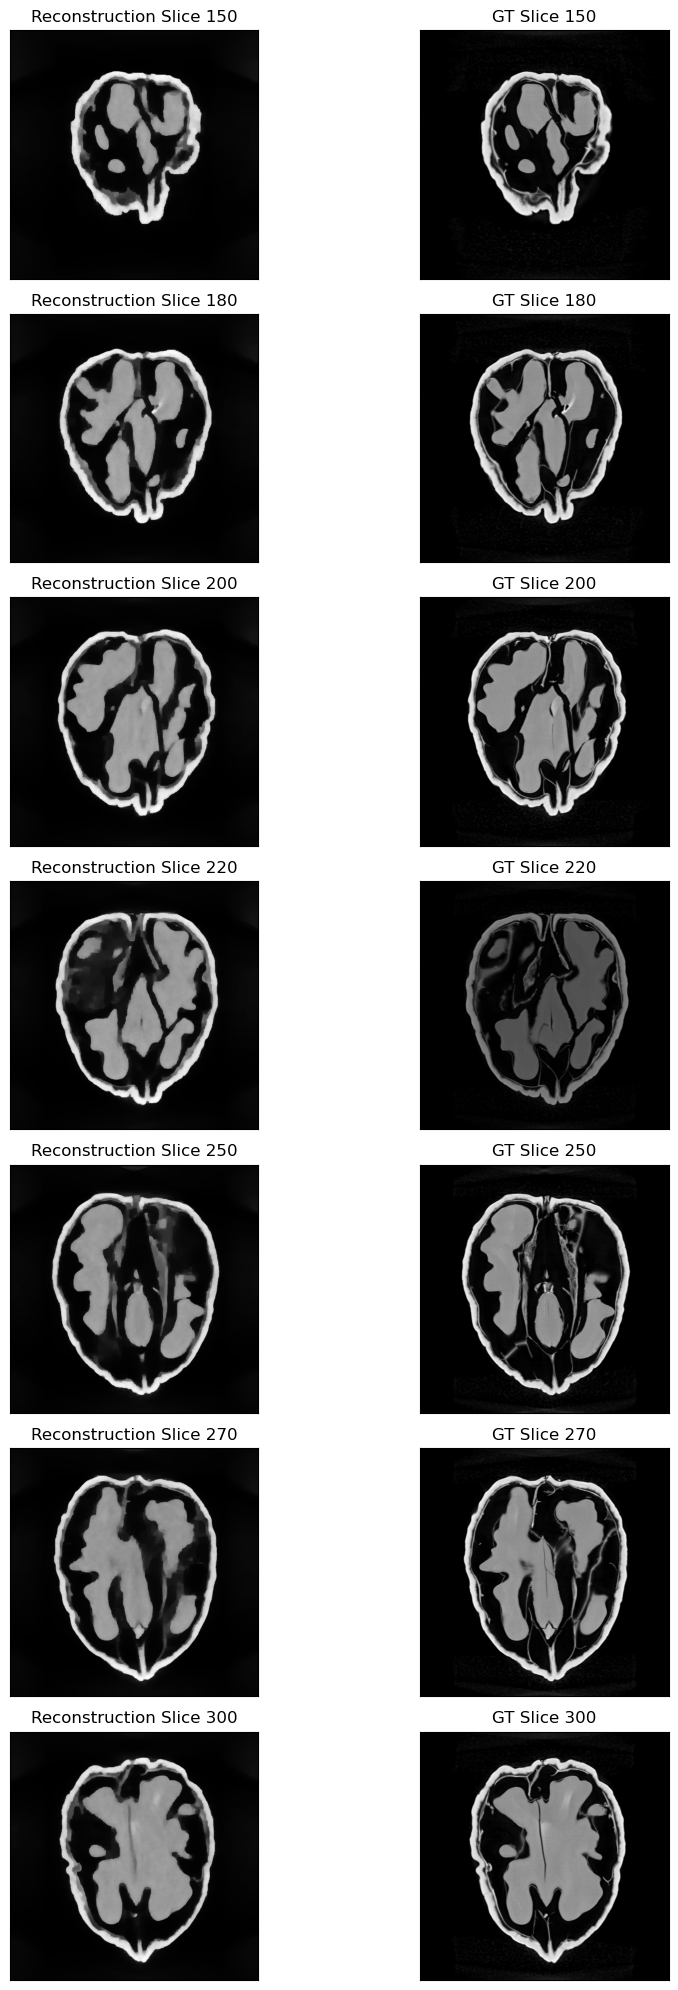

In [149]:
ind = [150, 180, 200, 220, 250, 270, 300]

fig, axes = plt.subplots(nrows=len(ind), ncols=2, figsize=(10, 20))
# Iterate over the slices and plot each pair in the respective subplot
for i, jdx in enumerate(ind):
    # Plot reconstructed slice
    # axes[i, 0].imshow(torch.clamp(recon.density[..., jdx].detach().cpu(), 0), cmap="gray")
    axes[i, 0].imshow(recon.density[..., jdx].detach().cpu(), cmap="gray",)
    axes[i, 0].set_title(f"Reconstruction Slice {jdx}")
    axes[i, 0].set_xticks([])
    axes[i, 0].set_yticks([])

    # Plot original slice
    # axes[i, 1].imshow(normalize(drr.density[..., jdx].detach().cpu()), cmap="gray")
    # axes[i, 1].imshow(recon.drr.density[..., jdx].detach().cpu(), cmap="gray", vmin=0, vmax=1)
  
    axes[i, 1].imshow(subject.volume.data.squeeze()[..., jdx].detach().cpu(), cmap="gray")

    axes[i, 1].set_title(f"GT Slice {jdx}")
    axes[i, 1].set_xticks([])
    axes[i, 1].set_yticks([])

# Adjust layout and save the figure
plt.tight_layout()